In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from sklearn.preprocessing import LabelEncoder

In [2]:
#viewing takehome user csv
#using 'latin-1' encoding because of "invalid continuation byte"
users = pd.read_csv('takehome_users.csv', encoding='latin-1')

#drop unneccesary columns
users = users.drop(columns= ['name', 'email'])
users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   creation_source             12000 non-null  object 
 3   last_session_creation_time  8823 non-null   float64
 4   opted_in_to_mailing_list    12000 non-null  int64  
 5   enabled_for_marketing_drip  12000 non-null  int64  
 6   org_id                      12000 non-null  int64  
 7   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(2)
memory usage: 750.1+ KB


In [4]:
#viewing engagement csv
engagement = pd.read_csv('takehome_user_engagement.csv')
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [6]:
# convert engagement time_stamp,  into to_datetime format
engagement['time_stamp'] = pd.to_datetime(
    engagement['time_stamp'], format='%Y-%m-%d %H:%M:%S')
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
#convert users columns into datetime as well
users['creation_time'] = pd.to_datetime(
    users['creation_time'], format='%Y-%m-%d %H:%M:%S')

users['last_session_creation_time'] = pd.to_datetime(
    users['last_session_creation_time'], unit='s')

#users.head()

In [8]:
#function to define adopted users (3 daily logins within 7 days)
def logins_in_days(df, days=7, logins=3):
    
    #drop duplicate days
    df['date'] = df['time_stamp'].dt.date
    
    #sort by day
    df = df.drop_duplicates(subset='date').sort_values('date')
    
    # calculate how many days has passed for every 3 logins
    passed_days = df['date'].diff(periods=logins-1)
    
    # check if any passed time is less than 7 days
    return any(passed_days <= timedelta(days=days))

In [9]:
# run the function on all users
adopted = engagement.groupby('user_id').apply(logins_in_days)
adopted.name = 'adopted_user'

In [10]:
#create column for user profile history, defined as time (in days) between creation_time and last_session_creation_time
users['profile_history'] = users['last_session_creation_time'] - users['creation_time']
users['profile_history'] = users['profile_history'].dt.days
#users.head()

In [11]:
#create profile age column, defined as between profile creation and when dataset was collected

latest = max(users.creation_time)

users['profile_age'] = latest - users['creation_time']
users['profile_age'] = users['profile_age'].dt.days
#users.head()

In [12]:
unique_users = len(engagement.user_id.unique())
unique_users

8823

In [13]:
#Sum of adopted users out of total users
print('There are a total of ' + str(adopted.sum()) + ' adopted users out of ' + str(unique_users) + ' users.')

There are a total of 1656 adopted users out of 8823 users.


Defining adopted user by users who have at least 3 logins within a 7 day period, there are a total of 1656 adopted users.

In [14]:
#setting index to object_id
users = users.set_index('object_id')

In [15]:
# merge user data and "adopted user" variable
users.index.name = 'user_id'
data = pd.concat([users, adopted], axis=1, join='inner')

#using numberical instead of True False for adopted user
data['adopted_user'] = data['adopted_user'].astype(int)

data.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,profile_history,profile_age,adopted_user
user_id,,,,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0,38,0
2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,136.0,196,1
3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0,437,0
4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1.0,374,0
5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,5.0,498,0


I can now drop the creation_time and last_session_creation_time variables, because I have the data I wanted from them in profile_history and profile_age variables

In [16]:
#dropping columns
data = data.drop(columns= ['creation_time','last_session_creation_time'])

In [17]:
#Encoding the creation source column

le = LabelEncoder()
creation_labels = le.fit_transform(data['creation_source'])
data.creation_source = creation_labels

#data.head()

In [18]:
data.isnull().sum()

creation_source                  0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            4047
profile_history                  0
profile_age                      0
adopted_user                     0
dtype: int64

In [19]:
#do the same for invited_by_user_id to remove the null values

invited_labels = le.fit_transform(data['invited_by_user_id'])
data.invited_by_user_id = invited_labels

data.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,profile_history,profile_age,adopted_user
user_id,,,,,,,,
1,0,1,0,11,2023,0.0,38,0
2,1,0,0,1,47,136.0,196,1
3,1,0,0,94,263,0.0,437,0
4,0,0,0,1,966,1.0,374,0
5,0,0,0,193,983,5.0,498,0


# EDA

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

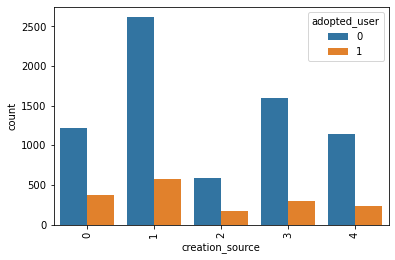

In [20]:
# Creation source and adopted user
sns.countplot(x='creation_source', data=data, hue='adopted_user')
plt.xticks(rotation=90)

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

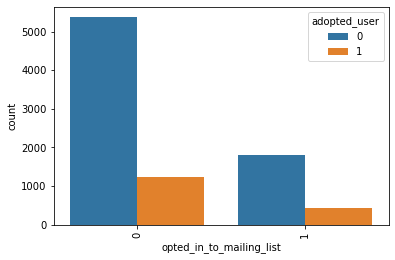

In [21]:
# opted_in_to_mailing_list and adopted user
sns.countplot(x='opted_in_to_mailing_list', data=data, hue='adopted_user')
plt.xticks(rotation=90)

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

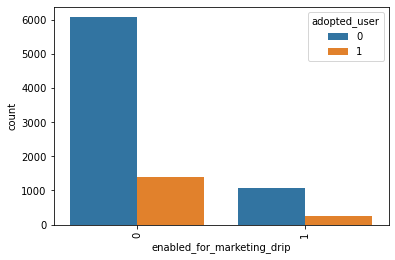

In [22]:
#enabled_for_marketing_drip and adopted user
sns.countplot(x='enabled_for_marketing_drip', data=data, hue='adopted_user')
plt.xticks(rotation=90)

# Analysis

Because the dataset we have is a mix of categorical and numberical values, the best model we can use for this dataset is a Random Forest Classifier.

In [23]:
#training the data

X = data.drop('adopted_user', axis = 1)

y = data.adopted_user

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 17)

In [24]:
#Fitting to Random Forest classifier
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

#Checking accuracy of model
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy score:  0.9524079320113314
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1409
           1       0.92      0.84      0.88       356

    accuracy                           0.95      1765
   macro avg       0.94      0.91      0.92      1765
weighted avg       0.95      0.95      0.95      1765



Accuracy score is really promising. I will use this model to find out feature importance before I make any recommendations

In [25]:
#feature importance
imp = pd.Series(rf.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

profile_history               0.845239
profile_age                   0.054218
org_id                        0.042518
invited_by_user_id            0.040841
creation_source               0.010890
opted_in_to_mailing_list      0.003449
enabled_for_marketing_drip    0.002846
dtype: float64


By finding feature importance it is pretty clear to see that profile history (the ammount of time in between the first log in and the most recent log in) was the greatest indicator of if a person will become a adopted user.

The strategy I would take to increase the rate of converting users into adopted users would be to encourage or incentivize the non-adopted users to use the product if there has been a period of time where the account was